In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

# Data source analysis

In this notebook, I will illustrate the process I followed in collecting and curating the data. I tried different dataset from different sources, checking if they were consistent before merging them if necessary.

I started with a dataset containing the monthly data and then searched for daily measurements. When possible, I searched and compared different sources to see if data where trustfully and coherent.

## Met Office Website

> Website: [Met Office Website, UK and regional series](https://www.metoffice.gov.uk/research/climate/maps-and-data/uk-and-regional-series)

From the UK and regional series webpage, this are the adopted criteria for downloading the data:
- Order: Year ordered statistics
- Region: England SE/Central S
- Parameter: Rainfall 

Header:
```
Areal values from HadUK-Grid 1km gridded climate data from land surface network
Source: Met Office National Climate Information Centre
Monthly, seasonal and annual total precipitation amount for England SE and Central S
Areal series, starting in 1836
Last updated 01-Jun-2025 11:46
```

In [2]:
data = pd.read_csv('./data/england_se_c.csv')
data.head()

,year,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,win,spr,sum,aut,ann
0,1836,67.7,59.0,103.1,90.7,21.5,39.9,65.1,64.4,94.8,126.1,100.0,60.1,---,215.3,169.4,320.9,892.3
1,1837,80.2,81.1,19.8,34.4,24.9,34.3,44.2,87.5,42.7,67.6,51.9,53.7,221.4,79.2,166.1,162.2,622.5
2,1838,12.9,58.1,37.6,22.7,28.6,91.8,44.0,37.9,85.9,68.5,122.8,69.1,124.7,88.9,173.7,277.3,679.9
3,1839,48.6,53.5,51.4,37.5,25.2,65.0,104.8,54.0,137.5,72.7,117.7,108.1,171.1,114.1,223.7,327.9,876.0
4,1840,87.0,49.3,7.6,5.0,53.2,34.0,59.9,49.9,82.8,38.9,121.6,12.7,244.5,65.8,143.8,243.3,601.9


In [3]:
data.columns

Index(['year', '   jan', '    feb', '    mar', '    apr', '    may', '    jun',
       '   jul', '   aug', '   sep', '   oct', '   nov', '   dec', '    win',
       '    spr', '    sum', '    aut', '    ann'],
      dtype='object')

The columns names contain some empty characters that need to be strip

In [4]:
data.dtypes

year         int64
   jan     float64
    feb    float64
    mar    float64
    apr    float64
    may    float64
    jun     object
   jul      object
   aug      object
   sep      object
   oct      object
   nov      object
   dec      object
    win     object
    spr    float64
    sum     object
    aut     object
    ann     object
dtype: object

Some columns are loaded as `object` type due to some `nan`s or special characters. They have to be converted into `float` type.

In [5]:
data.columns = data.columns.str.strip()
string_columns = data.select_dtypes(include=['object']).columns
data[string_columns] = data[string_columns].apply(pd.to_numeric, errors='coerce')
data_melt = data[['year', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep','oct', 'nov', 'dec']].melt(id_vars='year',var_name='month', value_name='value').sort_values(by='year')
data_melt['month'] = pd.Categorical(data_melt['month'], categories=['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'], ordered=True)
data_melt.rename(columns={'value': 'rainfall'}, inplace=True)

In [6]:
data_melt.head()

,year,month,rainfall
0,1836,jan,67.7
570,1836,apr,90.7
380,1836,mar,103.1
1330,1836,aug,64.4
1900,1836,nov,100.0


The feeling is that since I joined UK, the latest year has been drier with respect to the previous ones. I am taking into consideration the data starting from 2010 up to 2023 included to calculate the mean and median, and compare with data from 2024 onward.

In [7]:
rainfall_se_data = data_melt[data_melt['year'] >= 2010].copy()
rainfall_se_data

,year,month,rainfall
2074,2010,nov,76.6
1504,2010,aug,100.2
1314,2010,jul,26.1
744,2010,apr,22.7
934,2010,may,30.1
...,...,...,...
569,2025,mar,6.8
379,2025,feb,65.4
189,2025,jan,113.8
2089,2025,nov,NaN


In [8]:
rainfall_se_2010_2024 = (rainfall_se_data[rainfall_se_data['year'] < 2025]
 .groupby('year')
 .agg(
    total_rainfall=('rainfall', 'sum'),
    avg_rainfall=('rainfall', 'mean'),
    max_rainfall=('rainfall', 'max'),
    min_rainfall=('rainfall', 'min')
  )
 ).reset_index()


In [9]:
rainfall_se_2010_2024.head()

,year,total_rainfall,avg_rainfall,max_rainfall,min_rainfall
0,2010,689.6,57.466667,100.2,22.7
1,2011,630.6,52.550000,99.6,3.6
2,2012,1005.7,83.808333,142.5,19.3
3,2013,805.7,67.141667,161.3,22.8
4,2014,1039.0,86.583333,205.1,13.7


In the following plot I am considering just the sum or rainfall for each year and compare to 2024. I am also highlighting the value of year 2022 as in the summer of that year, in London a [hopepipe ban was issued](https://www.thameswater.co.uk/news/thames-water-lifts-hosepipe-ban) due to one of the driest years on record. 

Total Rainfall mean (2010-2023) = 818.42


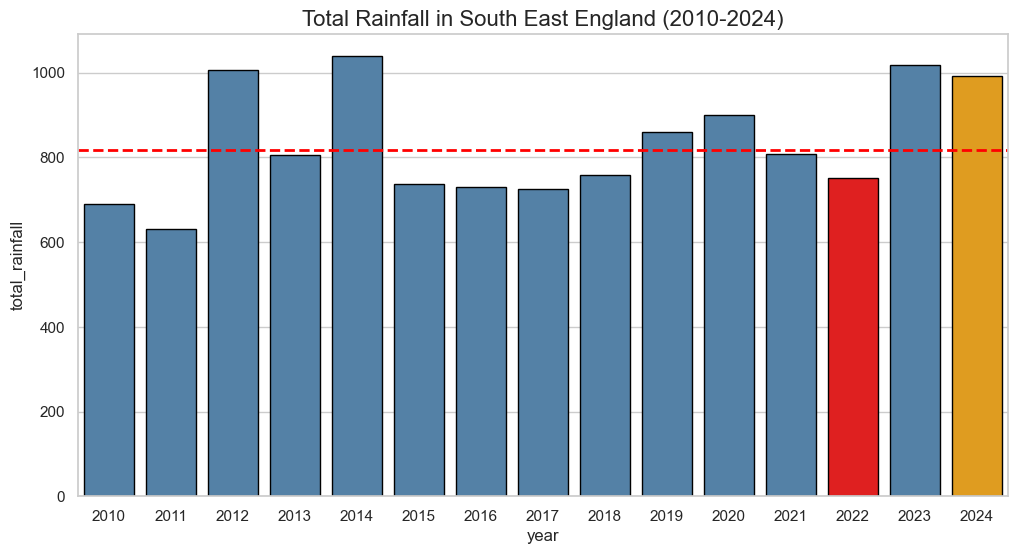

In [10]:
# Calculate the mean total rainfall for the years 2010-2023
# Note: The year 2024 is not included in the mean calculation as we want to compare it with the previous years.
rainfall_mean = rainfall_se_2010_2024[rainfall_se_2010_2024['year'] < 2024]['total_rainfall'].mean()

print("Total Rainfall mean (2010-2023) = {}".format(np.round(rainfall_mean, 2)))

years = sorted(rainfall_se_2010_2024['year'].unique())
colors = ['steelblue'] * len(years)

# Set special colors
last_year = max(years)
for i, year in enumerate(years):
    if year == 2022:
        colors[i] = 'red'      # Color for 2022
    elif year == last_year:
        colors[i] = 'orange'   # Color for last year


sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))

sns.barplot(x='year', 
            y='total_rainfall', 
            hue='year',
            data=rainfall_se_2010_2024,
            palette=colors,
            edgecolor='black',
            legend=False);
plt.title('Total Rainfall in South East England (2010-2024)', fontsize=16)

plt.axhline(y=rainfall_mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {rainfall_mean:.2f}');


In [11]:
# # Let's make a function that generalize the plot creation for generic starting and ending years

# def plot_rainfall(df, start_year, latest_year, feature = 'total_rainfall', special_year=2022, title_label ='Total Rainfall'):
#     rainfall_se_start_year_latest_year = df[(df['year'] >= start_year) & (df['year'] <= latest_year)].copy()
#     mean_previous_years = rainfall_se_start_year_latest_year[rainfall_se_start_year_latest_year['year'] < latest_year][feature].mean()

#     years = sorted(rainfall_se_start_year_latest_year['year'].unique())
#     colors = ['steelblue'] * len(years)

#     # Set special colors
#     for i, year in enumerate(years):
#         if year == special_year:
#             colors[i] = 'red'      # Color for 2022
#         elif year == latest_year:
#             colors[i] = 'orange'   # Color for last year

#     sns.set_theme(style="whitegrid")
#     plt.figure(figsize=(12, 6))

#     ax = sns.barplot(x='year', 
#                 y=feature, 
#                 hue='year',
#                 data=rainfall_se_start_year_latest_year,
#                 palette=colors,
#                 edgecolor='black',
#                 errorbar=None,
#                 legend=False);
    
#     # Custom formatting
#     for container in ax.containers:
#         ax.bar_label(container, fmt='%.1f', padding=3)
    
#     plt.title(f'{title_label} in South East England ({start_year}-{latest_year})', fontsize=16)
#     plt.axhline(y=mean_previous_years, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_previous_years:.2f}');
    
#     # Move legend to the right
#     plt.legend(bbox_to_anchor=(1., 1), loc='upper left')
#     plt.show()

In [12]:
from src.plotting import plot_rainfall

In [13]:
rainfall_se = (data_melt
               .groupby('year')
               .agg(
                   total_rainfall=('rainfall', 'sum'),
                   avg_rainfall=('rainfall', 'mean'),
                   median_rainfall=('rainfall', 'median'),
                   max_rainfall=('rainfall', 'max'),
                   min_rainfall=('rainfall', 'min')
                   )
                   ).reset_index()
rainfall_se.head()

,year,total_rainfall,avg_rainfall,median_rainfall,max_rainfall,min_rainfall
0,1836,892.4,74.366667,66.40,126.1,21.5
1,1837,622.3,51.858333,48.05,87.5,19.8
2,1838,679.9,56.658333,51.05,122.8,12.9
3,1839,876.0,73.000000,59.50,137.5,25.2
4,1840,601.9,50.158333,49.60,121.6,5.0


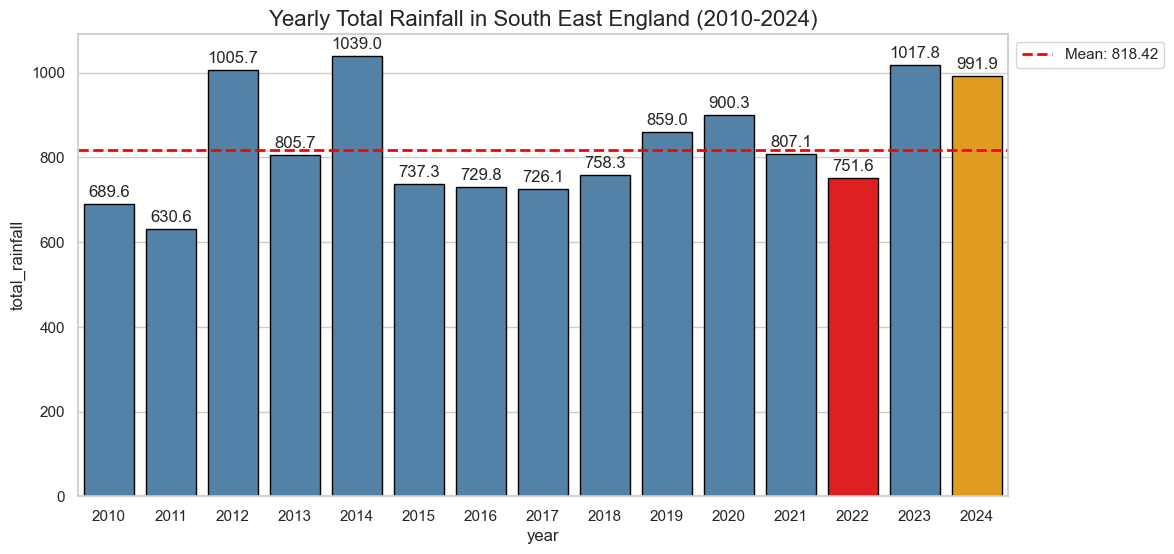

In [15]:
start_year = 2010
latest_yaer = 2024

plot_rainfall(rainfall_se, start_year, latest_yaer, feature='total_rainfall', special_year=2022, title_label='Yearly Total Rainfall', year_shift = False)

At least for year 2024, it doesn't look a particularly dry year. But what about considering also the the beginning of 2025? At first, I just considered the total precipitation per year, but what about the yearly monthly mean? In this way, I can also compare the latest data of 2025. 

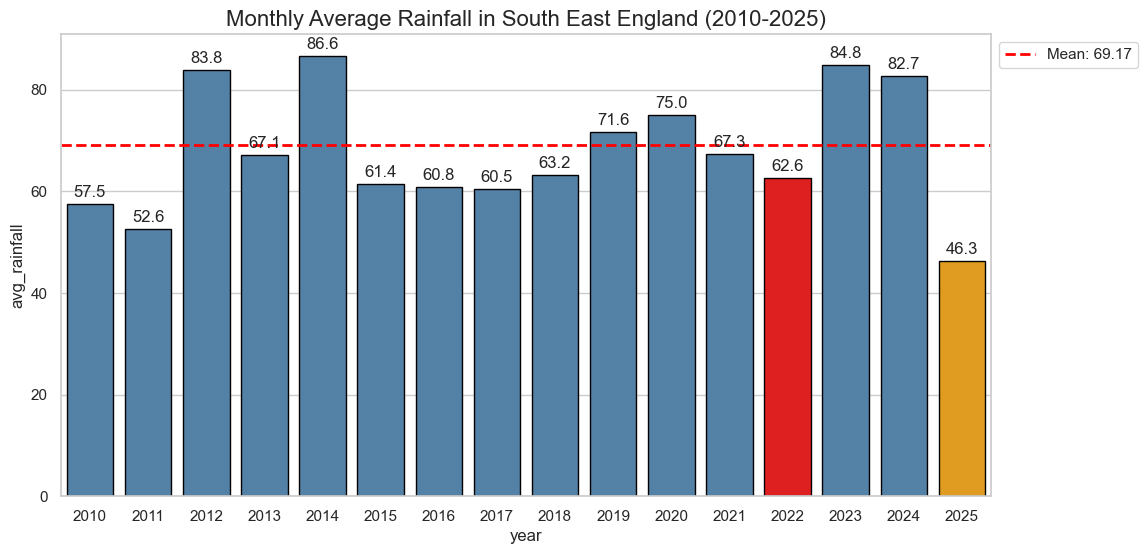

In [17]:
start_year = 2010
latest_yaer = 2025

plot_rainfall(rainfall_se, start_year, latest_yaer, feature='avg_rainfall', special_year=2022, title_label='Monthly Average Rainfall')

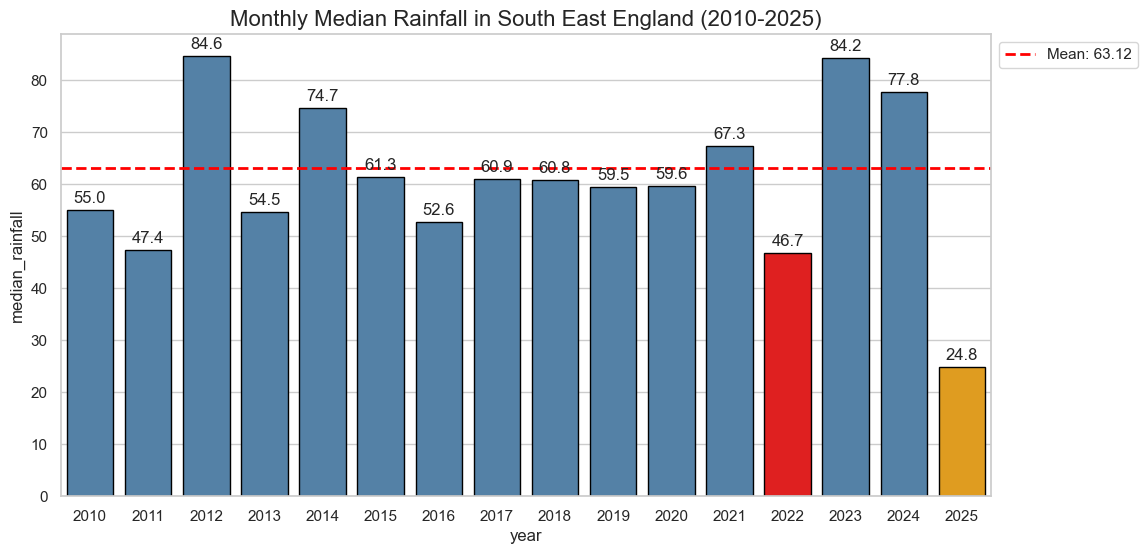

In [18]:
plot_rainfall(rainfall_se, start_year, latest_yaer, feature='median_rainfall', special_year=2022, title_label='Monthly Median Rainfall')

So, if we are having a look to the first 5 months of 2025, the monthly mean looks actually significantly (I am not saying *is* statistically significantly) lower than the previous year. But one could argue that we are just comparing the first 5 months of the year, it could just be that for the first 5 months of the year, each year, the mean might be lower than the rest of the year. The next step is to compare the first 5 months of each year and see what the mean can tell us. 

In [19]:
months_compare = ['jan', 'feb', 'mar', 'apr', 'may']
rainfall_se_jan_to_may = (data_melt[data_melt['month'].isin(months_compare)]
                          .groupby('year')
                          .agg(
                              total_rainfall=('rainfall', 'sum'),
                              avg_rainfall=('rainfall', 'mean'),
                              median_rainfall=('rainfall', 'median'),
                              max_rainfall=('rainfall', 'max'),
                              min_rainfall=('rainfall', 'min')
                              )
                              ).reset_index()

rainfall_se_jan_to_may.head()

,year,total_rainfall,avg_rainfall,median_rainfall,max_rainfall,min_rainfall
0,1836,342.0,68.40,67.7,103.1,21.5
1,1837,240.4,48.08,34.4,81.1,19.8
2,1838,159.9,31.98,28.6,58.1,12.9
3,1839,216.2,43.24,48.6,53.5,25.2
4,1840,202.1,40.42,49.3,87.0,5.0


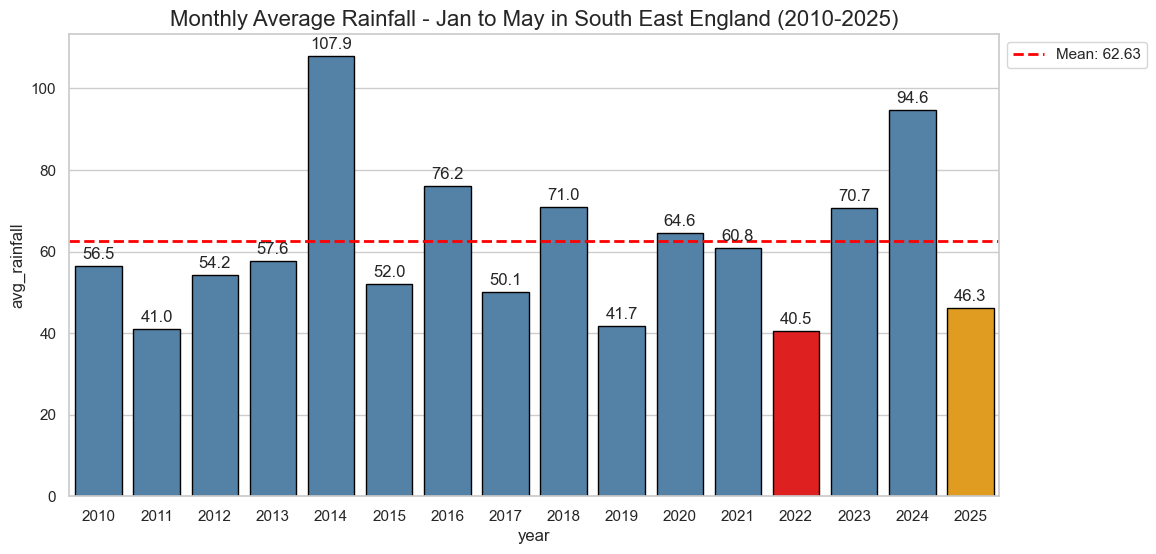

In [20]:
start_year = 2010
latest_yaer = 2025

plot_rainfall(rainfall_se_jan_to_may, start_year, latest_yaer, feature='avg_rainfall', special_year=2022, title_label='Monthly Average Rainfall - Jan to May')

In [21]:
rainfall_se_jan_to_may[rainfall_se_jan_to_may['year'] >= 2010][['year', 'total_rainfall', 'avg_rainfall', 'median_rainfall']].sort_values(by='total_rainfall', ascending=True).reset_index(drop=True)[:6]

,year,total_rainfall,avg_rainfall,median_rainfall
0,2022,202.5,40.50,42.7
1,2011,205.1,41.02,27.2
2,2019,208.7,41.74,32.8
3,2025,231.3,46.26,24.8
4,2017,250.6,50.12,50.1
5,2015,259.8,51.96,58.6


In [22]:
conds=[
    data_melt['month'].isin(['mar', 'apr', 'may']),
    data_melt['month'].isin(['jun', 'jul', 'aug']),
    data_melt['month'].isin(['sep', 'oct', 'nov']),
    data_melt['month'].isin(['dec', 'jan', 'feb'])
]
choices=['spring', 'summer', 'autumn', 'winter']
data_melt['season'] = np.select(conds, choices, default='unknown')
data_melt.head()

,year,month,rainfall,season
0,1836,jan,67.7,winter
570,1836,apr,90.7,spring
380,1836,mar,103.1,spring
1330,1836,aug,64.4,summer
1900,1836,nov,100.0,autumn


In [23]:
# Create month order mapping
month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 
               'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

# Function to assign season and season year
def assign_season(row):
    month = row['month'].lower()
    year = row['year']
    
    if month in ['jun', 'jul', 'aug', 'sep', 'oct', 'nov']:
        return 'Jun-Nov', year
    elif month in ['dec', 'jan', 'feb', 'mar', 'apr', 'may']:
        # For Dec-May season, December belongs to the previous calendar year's season
        if month == 'dec':
            return 'Dec-May', year + 1
        else:
            return 'Dec-May', year
        
# Apply the function to create season columns
df_temp = data_melt.copy()
df_temp[['semester', 'semester_year']] = df_temp.apply(
    assign_season, axis=1, result_type='expand'
)

df_temp.head()

,year,month,rainfall,season,semester,semester_year
0,1836,jan,67.7,winter,Dec-May,1836
570,1836,apr,90.7,spring,Dec-May,1836
380,1836,mar,103.1,spring,Dec-May,1836
1330,1836,aug,64.4,summer,Jun-Nov,1836
1900,1836,nov,100.0,autumn,Jun-Nov,1836


In [24]:
# Function to assign water year (June to May)

def assign_water_year(row):
    month = row['month'].lower()
    year = row['year']
    
    # June to December belong to the water year starting in that calendar year
    if month in ['jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']:
        return year
    # January to May belong to the water year that started in the previous calendar year
    else:  # jan, feb, mar, apr, may
        return year - 1

# Apply the function to create water year column
# df_temp = df.copy()
df_temp['water_year'] = df_temp.apply(assign_water_year, axis=1)
df_temp.head()

,year,month,rainfall,season,semester,semester_year,water_year
0,1836,jan,67.7,winter,Dec-May,1836,1835
570,1836,apr,90.7,spring,Dec-May,1836,1835
380,1836,mar,103.1,spring,Dec-May,1836,1835
1330,1836,aug,64.4,summer,Jun-Nov,1836,1836
1900,1836,nov,100.0,autumn,Jun-Nov,1836,1836


In [25]:
df_temp.tail()

,year,month,rainfall,season,semester,semester_year,water_year
569,2025,mar,6.8,spring,Dec-May,2025,2024
379,2025,feb,65.4,winter,Dec-May,2025,2024
189,2025,jan,113.8,winter,Dec-May,2025,2024
2089,2025,nov,NaN,autumn,Jun-Nov,2025,2025
2279,2025,dec,NaN,winter,Dec-May,2026,2025


In [26]:
df_temp[(df_temp['water_year'] >= 2010) & (df_temp['water_year'] <= 2024)]

,year,month,rainfall,season,semester,semester_year,water_year
2074,2010,nov,76.6,autumn,Jun-Nov,2010,2010
1504,2010,aug,100.2,summer,Jun-Nov,2010,2010
1314,2010,jul,26.1,summer,Jun-Nov,2010,2010
1884,2010,oct,78.5,autumn,Jun-Nov,2010,2010
1124,2010,jun,32.8,summer,Jun-Nov,2010,2010
...,...,...,...,...,...,...,...
949,2025,may,20.5,spring,Dec-May,2025,2024
759,2025,apr,24.8,spring,Dec-May,2025,2024
569,2025,mar,6.8,spring,Dec-May,2025,2024
379,2025,feb,65.4,winter,Dec-May,2025,2024


In [27]:
# Compute yearly statistics for each water year
water_yearly_stats = df_temp[(df_temp['water_year'] >= 2010) & (df_temp['water_year'] <= 2024)].groupby('water_year')['rainfall'].agg([
    'sum','mean', 'median', 'min', 'max'
]).reset_index()

# Rename columns for clarity
water_yearly_stats.columns = ['year', 'total_rainfall','avg_rainfall', 'median_rainfall', 
                       'min_rainfall', 'max_rainfall']

water_yearly_stats.head()

,year,total_rainfall,avg_rainfall,median_rainfall,min_rainfall,max_rainfall
0,2010,612.4,51.033333,46.55,3.6,100.2
1,2011,696.6,58.050000,47.15,19.3,133.8
2,2012,1022.6,85.216667,75.80,38.1,142.5
3,2013,1057.1,88.091667,72.85,22.8,205.1
4,2014,759.4,63.283333,56.30,13.7,135.6


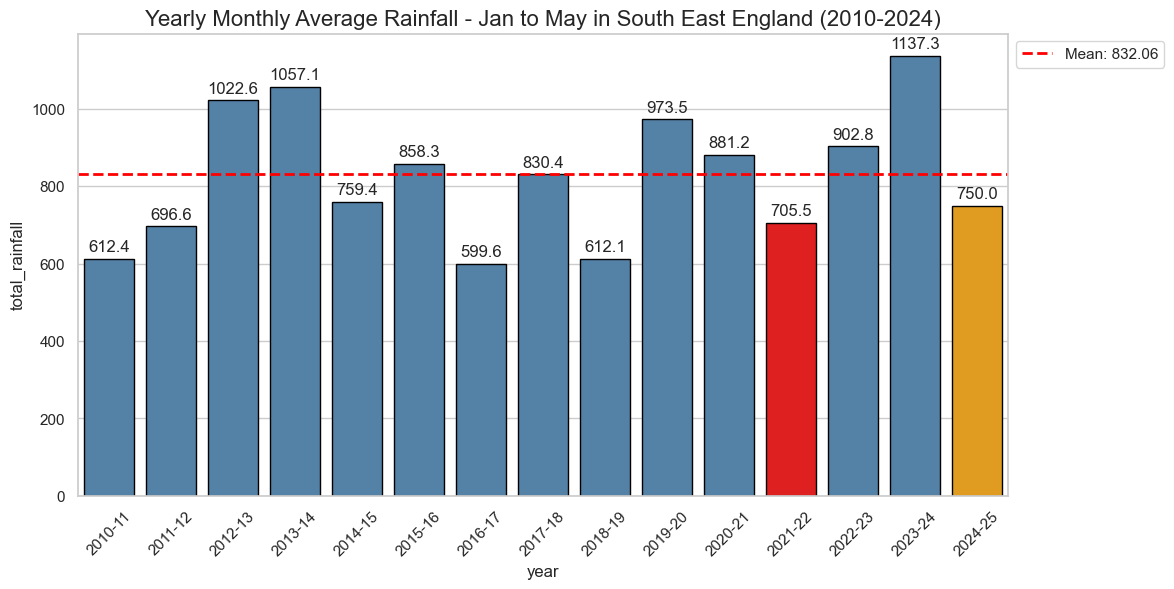

In [31]:
start_year = 2010
latest_yaer = 2024

plot_rainfall(water_yearly_stats, start_year, latest_yaer, feature='total_rainfall', special_year=2021, title_label='Yearly Monthly Average Rainfall - Jan to May', year_shift=True)

If we rank the 2024-25 season, we can see that even if below average, still does not look as a particular dry year

In [ ]:
sorted_dataframe = water_yearly_stats.sort_values(['total_rainfall']).reset_index(drop=True)
sorted_dataframe['Year'] = sorted_dataframe['year'].astype(str)+'-'+(sorted_dataframe['year']+1).astype(str).str[-2:]
sorted_dataframe['Rank'] = sorted_dataframe.index + 1
index_2024 = sorted_dataframe[sorted_dataframe['year'] == 2024].index[0]


# Highlight specific rows (e.g., rows 1 and 3)
def highlight_rows(s):
    return ['background-color: #2d5a87' if s.name in [index_2024] else '' for _ in s]

sorted_dataframe[['Year', 'Rank', 'total_rainfall', 'avg_rainfall', 'median_rainfall']].style.hide(axis='index').apply(highlight_rows, axis=1)

Year,Rank,total_rainfall,avg_rainfall,median_rainfall
2016-17,1,599.600000,49.966667,45.950000
2018-19,2,612.100000,51.008333,45.800000
2010-11,3,612.400000,51.033333,46.550000
2011-12,4,696.600000,58.050000,47.150000
2021-22,5,705.500000,58.791667,51.500000
2024-25,6,750.000000,62.500000,58.350000
2014-15,7,759.400000,63.283333,56.300000
2017-18,8,830.400000,69.200000,71.100000
2015-16,9,858.300000,71.525000,65.500000
2020-21,10,881.200000,73.433333,59.350000


In [ ]:

sorted_dataframe

,year,total_rainfall,avg_rainfall,median_rainfall,min_rainfall,max_rainfall,Year,rank
0,2016,599.6,49.966667,45.95,8.5,100.7,2016-17,1
1,2018,612.1,51.008333,45.80,2.8,113.9,2018-19,2
2,2010,612.4,51.033333,46.55,3.6,100.2,2010-11,3
3,2011,696.6,58.050000,47.15,19.3,133.8,2011-12,4
4,2021,705.5,58.791667,51.50,14.2,137.2,2021-22,5
5,2024,750.0,62.500000,58.35,6.8,157.4,2024-25,6
6,2014,759.4,63.283333,56.30,13.7,135.6,2014-15,7
7,2017,830.4,69.200000,71.10,29.8,106.4,2017-18,8
8,2015,858.3,71.525000,65.50,26.4,131.2,2015-16,9
9,2020,881.2,73.433333,59.35,10.0,182.4,2020-21,10


In [37]:
# Sample DataFrame
df = pd.DataFrame({
    'A': [1, 2, 3, 4, 5],
    'B': [10, 20, 30, 40, 50],
    'C': [100, 200, 300, 400, 500]
})

# Highlight specific rows (e.g., rows 1 and 3)
def highlight_rows(s):
    return ['background-color: yellow' if s.name in [1, 3] else '' for _ in s]

df.style.apply(highlight_rows, axis=1)

,A,B,C
0,1,10,100
1,2,20,200
2,3,30,300
3,4,40,400
4,5,50,500


In [ ]:
water_yearly_stats['year'].astype(str)+'-'+(water_yearly_stats['year']+1).astype(str).str[-2:]

In [ ]:
(water_yearly_stats['year']+1).astype(str).str[-2:]

In [ ]:
data_melt[data_melt['year'] == 2025].sort_values('month')['rainfall'].sum()

In [ ]:
231.3/5

In [ ]:
data_melt[data_melt['year'] == 2025].sort_values('month')['rainfall'].mean()

In [ ]:
data_melt[data_melt['year'] == 2025]

In [ ]:
rainfall_se.head()

In [ ]:
# rainfall_se_data[rainfall_se_data['year'] == 2024]['rainfall'].sum()

## ECA&D Website

Website: [European Climate Assessment and Dataset](https://www.ecad.eu/)


We have [7 different monitoring stations](https://knmi-ecad-assets-prd.s3.amazonaws.com/download/stations.txt) in the nearby of London that I can take into consideration:

| Station ID | Station Name | Latitude | Longitude | Elevation (in m) |
| ---------- | ------------ | -------- | --------- | ---------------- |
| 459 | LONDON, GB | +51:27:36 | +000:00:00 |   24 |
| 2128 * | LONDON/GATWICK, GB | +51:09:00 | -000:10:48 | 62 |
| 1860 * | HEATHROW,GB | +51:28:44 | -000:26:56 |   25 |
| 16445 * | KEW,GB |+51:28:03 | -000:18:50 |    5 |
| 16444 | LONDONWEATHER CENTRE, GB | +51:31:00 | -000:07:00 | 77 |
| 17476 * | LONDON ST JAMES'S PARK,GB | +51:30:15 |-000:07:45 | 5 |
| 21976 *| LONDON-WEATHER-CENTRE,GB | +51:31:18 | -000:06:42 | 43 |

### Blended vs Non Blended data


From the [ECA&D FAQ page](https://www.ecad.eu/FAQ/index.php#3)

The series collected from participating countries generally do not contain data for the most recent years. This is partly due to the time that is needed for data quality control and archiving at the home institutions of the participants, and partly the result of the efforts required to include the data in the ECA database. To make available for each station a time series that is as complete as possible, we have included an automated update procedure that relies on the daily data from SYNOP messages that are distributed in near real time over the Global Telecommunication System (GTS). In this procedure the gaps in a daily series are also infilled with observations from nearby stations, provided that they are within 12.5km distance and that height differences are less than 25m.

The download options under daily data allow to select blend or non-blend. 

> *The non-blended series are the series as provided by the participants. The blended series underwent the process described above. In case a blended series is chosen, information on the underlying series that are used in the blending process is provided.*

In this notebook, I collected both blended and non blended data for all 5 stations. The idea, is to merge all non blended data (issue of missing data) and see if we come up with a coherent dataset.

In [ ]:
def transform_data_datetime(df):
    df = df.copy()
    df['datetime'] = pd.to_datetime(df['DATE'], format="%Y%m%d")
    df['year'] = df['datetime'].dt.year
    df['month int'] = df['datetime'].dt.month
    df['month'] = df['datetime'].dt.strftime('%b')
    df['day'] = df['datetime'].dt.day

    return df

### Gatwick Data

In [ ]:
data = pd.read_csv('./data/non_blended/London_Gatwick_2128_RR_SOUID221586.csv')
data.head()

In [ ]:
data_Gatwick_non_blended = transform_data_datetime(data)
data_Gatwick_non_blended.head()

### Heathrow Data

As for the Heathrow data, we have 2 dataset available. One covers data starting from 1960, the other one starting from 1980. The first dataset also contains more "reliable" data. I also compared the two dataset to see if they contain measurements that are consistent between each other (in terms of reported precipitation in mm for each day)

In [ ]:
data = pd.read_csv('./data/non_blended/London_Heathrow_1860_1_RR_SOUID107650.csv')
data.head()

In [ ]:
data_Heathrow_1_non_blended = transform_data_datetime(data)
data_Heathrow_1_non_blended.head()

In [ ]:
data = pd.read_csv('./data/non_blended/London_Heathrow_1860_2_RR_SOUID219137.csv')
data.head()

In [ ]:
data_Heathrow_2_non_blended = transform_data_datetime(data)
data_Heathrow_2_non_blended.head()

In [ ]:
data_Heathrow_1_non_blended[(data_Heathrow_1_non_blended['year'] == 1980) & 
                            (data_Heathrow_1_non_blended['month'] == 'Jul')]['RR'].sum()

In [ ]:
data_Heathrow_2_non_blended[(data_Heathrow_2_non_blended['year'] == 1980) & 
                            (data_Heathrow_2_non_blended['month'] == 'Jul')]['RR'].sum()

In [ ]:
test_1980_1 = data_Heathrow_1_non_blended[data_Heathrow_1_non_blended['year'] == 1980]
test_1980_2 = data_Heathrow_2_non_blended[data_Heathrow_2_non_blended['year'] == 1980]

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.lineplot(
    data = test_1980_1,
    x = 'datetime',
    y = 'RR',
    ax=ax,
    label='Heathrow 1'
)

sns.lineplot(
    data = test_1980_2,
    x = 'datetime',
    y = 'RR',
    ax=ax,
    label='Heathrow 2'
)


### Kew Garden

In [ ]:
data = pd.read_csv('./data/non_blended/London_KG_21975_RR_SOUID219141.csv')
print(data.shape)
data.head()

In [ ]:
data_KG_non_blended = transform_data_datetime(data)
data_KG_non_blended.head()

### St. James Park

In [ ]:
data = pd.read_csv('./data/non_blended/London_SJP_17476_RR_SOUID219145.csv')
print(data.shape)
data.head()

In [ ]:
data_SJP_non_blended = transform_data_datetime(data)
data_SJP_non_blended.head()

In [ ]:
data_SJP_non_blended[data_SJP_non_blended['Q_RR'] != 0].shape

### London Weather Center

In [ ]:
data = pd.read_csv('./data/non_blended/London_WC_21976_RR_SOUID219147.csv')
print(data.shape)
data.head()

In [ ]:
data_WC_non_blended = transform_data_datetime(data)
data_WC_non_blended.head()

## Data Cleaning

I am starting by considering the St. James Park data (the closest station to where I live) and fill the missing reading with the other available data - Kew Garden first and Heathrow.

In [ ]:
data_SJP_non_blended[data_SJP_non_blended['Q_RR'] != 0].shape

In [ ]:
data_SJP_non_blended[data_SJP_non_blended['Q_RR'] != 0].shape[0]/ data_SJP_non_blended.shape[0]

In [ ]:
data_KG_non_blended[data_KG_non_blended['Q_RR'] != 0].shape[0]/ data_KG_non_blended.shape[0]

In [ ]:
data_SJP_non_blended['datetime'].min()

In [ ]:
data_KG_non_blended['datetime'].min()

In [ ]:
data_SJP_2010 = data_SJP_non_blended[data_SJP_non_blended['datetime'] > '2010-01-01'].copy()
data_KG_2010 = data_KG_non_blended[data_KG_non_blended['datetime'] > '2010-01-01'].copy()
print(data_SJP_2010.shape, data_KG_2010.shape)

In [ ]:
data_SJP_2010[data_SJP_2010['Q_RR'] != 0].shape

In [ ]:
data_KG_2010[data_KG_2010['Q_RR'] != 0].shape

In [ ]:
sns.scatterplot(
    data=data_KG_2010,
    x='datetime',
    y='RR'
    )

In [ ]:
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

sns.scatterplot(
    data=data_Heathrow_1_non_blended[data_Heathrow_1_non_blended['year'] > 2010],
    x='datetime',
    y='RR'
    );

So, basically, after searching data for hours, I came to the conclusion that the best dataset for my purpose was just the one from Heathrow as it doesn't contain any ureliable data. All inconsistent data are prior of 2010.

> Lesson learned: Set up your constrains and then check if the data fit the purpose as soon as you download it

In [ ]:
data_Heathrow_1_non_blended[data_Heathrow_1_non_blended['Q_RR'] != 0]

In [ ]:
rainfall_data = data_Heathrow_1_non_blended[(data_Heathrow_1_non_blended['year'] >= 2010) & (data_Heathrow_1_non_blended['year'] <2025)].copy() 

rainfall_data.month = pd.Categorical(
    rainfall_data.month,
    categories=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
    ordered=True
)

In [ ]:
sns.set_theme(rc={'figure.figsize':(12.,6.)})

sns.scatterplot(
    data=rainfall_data,
    x='datetime',
    y='RR'
    );

In [ ]:
print(rainfall_data['datetime'].min())
print(rainfall_data['datetime'].max())

In [ ]:
precipitation_by_year_month = (rainfall_data
 .groupby(['year', 'month'], observed=False)
 .agg
 (
     precipitation_sum=('RR', 'sum'),
     precipitation_mean=('RR', 'mean'),
     precipitation_std=('RR', 'std'),
     precipitation_median=('RR', 'median'),
     precipitation_max=('RR', 'max'),
     precipitation_min=('RR', 'min')
 )
 ).reset_index()

In [ ]:
precipitation_by_year_month.head()

In [ ]:
rainfall_data[(rainfall_data['year'] == 2010) & (rainfall_data['month'] == 'Jan')]['RR'].sum()

In [ ]:
rainfall_data[(rainfall_data['year'] == 2010) & (rainfall_data['month'] == 'Jan')]['RR'].mean()

In [ ]:
data = pd.read_csv('./data/south_east_rainfall.csv')

data.columns = data.columns.str.strip()
string_columns = data.select_dtypes(include=['object']).columns
data[string_columns] = data[string_columns].apply(pd.to_numeric, errors='coerce')
data_melt = data[['year', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep','oct', 'nov', 'dec']].melt(id_vars='year',var_name='month', value_name='value').sort_values(by='year')
data_melt['month'] = pd.Categorical(data_melt['month'], categories=['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'], ordered=True)

In [ ]:
rainfall_data_south_east = data_melt[(data_melt['year'] >= 2010) & (data_melt['year'] < 2025)].sort_values(by=['year', 'month']).reset_index(drop=True)

In [ ]:
rainfall_data_heathrow = precipitation_by_year_month.copy()
rainfall_data_heathrow.head()

In [ ]:
rainfall_data_south_east.head()

In [ ]:
rainfall_data_heathrow.dtypes

In [ ]:
rainfall_data_south_east['month'] = rainfall_data_south_east['month'].str.capitalize()  # jan -> Jan
# df['datetime'] = pd.to_datetime(df[['Year', 'Month']].assign(day=1))

In [ ]:
rainfall_data_south_east['datetime'] = pd.to_datetime(rainfall_data_south_east['year'].astype(str) + '-' + rainfall_data_south_east['month'] + '-01', format='%Y-%b-%d')

In [ ]:
rainfall_data_heathrow['datetime'] = pd.to_datetime(rainfall_data_heathrow['year'].astype(str) + '-' + rainfall_data_heathrow['month'].astype(str) + '-01', format='%Y-%b-%d')
# rainfall_data_south_east.dtypes

In [ ]:
rainfall_data_heathrow

In [ ]:
rainfall_heathrow = rainfall_data_heathrow[['datetime', 'precipitation_sum', 'precipitation_mean']].rename(
    columns={
        'precipitation_sum': 'Heathrow Sum',
        'precipitation_mean': 'Heathrow Mean'
    }
)

rainfall_south_east = rainfall_data_south_east[['datetime', 'value']].rename(
    columns={
        'value': 'South East Sum'
    }
)

In [ ]:
rainfall_heathrow.head()

In [ ]:
rainfall_south_east.head()

In [ ]:
rainfall_compare = rainfall_heathrow.merge(
    rainfall_south_east,
    on='datetime',
    how='outer'
)

In [ ]:
rainfall_compare[['Heathrow Sum', 'South East Sum']].corr()

In [ ]:
rainfall_compare[['Heathrow Mean', 'South East Sum']].corr()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.lineplot(
    data = rainfall_compare,
    x = 'datetime',
    y = 'Heathrow Mean',
    ax=ax,
    label='Heathrow'
)

sns.lineplot(
    data = rainfall_compare,
    x = 'datetime',
    y = 'South East Sum',
    ax=ax,
    label='South East'
)


In [ ]:
rainfall_data.corr()

### Blended - St James park and London central

In [ ]:
# St. James park data BLENDED
data_sjp_blended = pd.read_csv('./data/RR_STAID017476_blended.csv')
# Convert the 'DATE' column to datetime format
data_sjp_blended['datetime'] = pd.to_datetime(data_sjp_blended['DATE'], format="%Y%m%d")
# Creating year, month, and day columns 
data_sjp_blended['year'] = data_sjp_blended['datetime'].dt.year
data_sjp_blended['month int'] = data_sjp_blended['datetime'].dt.month
data_sjp_blended['month'] = data_sjp_blended['datetime'].dt.strftime('%b')
data_sjp_blended['day'] = data_sjp_blended['datetime'].dt.day
# display the first few rows of the dataframe
print(data_sjp_blended.shape)
data_sjp_blended.head()

In [ ]:
# London park data BLENDED
data_lon_blended = pd.read_csv('./data/London_blended_RR_STAID021976.csv')
# Convert the 'DATE' column to datetime format
data_lon_blended['datetime'] = pd.to_datetime(data_lon_blended['DATE'], format="%Y%m%d")
# Creating year, month, and day columns 
data_lon_blended['year'] = data_lon_blended['datetime'].dt.year
data_lon_blended['month int'] = data_lon_blended['datetime'].dt.month
data_lon_blended['month'] = data_lon_blended['datetime'].dt.strftime('%b')
data_lon_blended['day'] = data_lon_blended['datetime'].dt.day
# display the first few rows of the dataframe
print(data_lon_blended.shape)
data_lon_blended.head()

In [ ]:
# London park data NON BLENDED
data_lon_non_blended = pd.read_csv('./data/London_non_blended_RR_SOUID219147.csv')
# Convert the 'DATE' column to datetime format
data_lon_non_blended['datetime'] = pd.to_datetime(data_lon_non_blended['DATE'], format="%Y%m%d")
# Creating year, month, and day columns 
data_lon_non_blended['year'] = data_lon_non_blended['datetime'].dt.year
data_lon_non_blended['month int'] = data_lon_non_blended['datetime'].dt.month
data_lon_non_blended['month'] = data_lon_non_blended['datetime'].dt.strftime('%b')
data_lon_non_blended['day'] = data_lon_non_blended['datetime'].dt.day
# display the first few rows of the dataframe
print(data_lon_non_blended.shape)
data_lon_non_blended.head()

In [ ]:
# London Kew Garded data NON BLENDED
data_KG_non_blended = pd.read_csv('./data/London_KG_non_blended_RR_SOUID219141.csv')
# Convert the 'DATE' column to datetime format
data_KG_non_blended['datetime'] = pd.to_datetime(data_KG_non_blended['DATE'], format="%Y%m%d")
# Creating year, month, and day columns 
data_KG_non_blended['year'] = data_KG_non_blended['datetime'].dt.year
data_KG_non_blended['month int'] = data_KG_non_blended['datetime'].dt.month
data_KG_non_blended['month'] = data_KG_non_blended['datetime'].dt.strftime('%b')
data_KG_non_blended['day'] = data_KG_non_blended['datetime'].dt.day
# display the first few rows of the dataframe
print(data_KG_non_blended.shape)
data_KG_non_blended.head()

In [ ]:
data_lon_non_blended[data_lon_non_blended['Q_RR'] != 0].shape

In [ ]:
(data_sjp_blended
 .groupby(['year', 'month int'])
 .agg({'RR': 'sum'})
).reset_index()[45:55]

In [ ]:
(data_lon_blended
 .groupby(['year', 'month int'])
 .agg({'RR': 'sum'})
).reset_index()[152:162]

In [ ]:
data_lon_blended[data_lon_blended['datetime'].isin(list(data_sjp_blended[data_sjp_blended['Q_RR'] != 0]['datetime'].values))].tail()

In [ ]:
data_lon_non_blended[data_lon_non_blended['datetime'].isin(list(data_sjp_blended[data_sjp_blended['Q_RR'] != 0]['datetime'].values))].head()

In [ ]:
data_KG_non_blended[(data_KG_non_blended['datetime'].isin(list(data_sjp_blended[data_sjp_blended['Q_RR'] != 0]['datetime'].values))) & 
                    (data_KG_non_blended['Q_RR'] == 0)]

## Met Office Data

- [Met Office Websise](https://www.metoffice.gov.uk/research/climate/maps-and-data/historic-station-data)
- [London Heathrow](https://www.metoffice.gov.uk/pub/data/weather/uk/climate/stationdata/heathrowdata.txt)